In [17]:
import pandas as pd
from vnstock import Vnstock
import datetime
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
from vnstock import Vnstock

class Helper:

    @staticmethod
    def normalize_to_1(mat:np.array):
        total = np.sum(mat)
        return mat / total
    @staticmethod
    def find_risk_free_rate():
        pass
    @staticmethod
    def historical_data(stock:str,
                        start_date:str,
                        end_date:str,
                        engine:str,
                        include = ["time","open","close"]):
        history = defaultdict()
        #perform search by vnstock library
        if engine == "vnstock":
            stock_obj = Vnstock().stock(symbol=stock, source="VCI")
            stock_data = stock_obj.quote.history(start=start_date, end=end_date, interval="1D")
            if stock_data.empty:
                print(f"No data for {stock}")
            else:
                for key in include:
                    if key in stock_data.columns:
                        history[key] = stock_data[key].copy()
        #return a dictionary history {"time", "open","close": 
        # each with a row of data assigned }
        return history
    @staticmethod
    def calculate_variance(hpr_df:pd.DataFrame,weight:list):
        hpr_df.pct_change()
class Portfolio():
    def __init__(self, stocks: list, weight_list: list, start_year_previous=5,):
        #normalize weight to sum 1
        if len(stocks) != len(weight_list):
            raise ValueError("Length of weight_list must equal length of stockS")
        self.weight_list = Helper.normalize_to_1(np.array(weight_list))
        self.stocks = stocks
        #history is stored as {"symbol":{"close: []"
        #                                 "open":[]
        #                                 "time":[]
        #                                 "return":[]
        #                                   }}
        #                      
        self.history = defaultdict(list)
        #calculate date
        today = datetime.date.today()  # 02:16 PM +07, Aug 29, 2025
        start = str(today.replace(year=today.year - start_year_previous))
        end = str(today.replace(day=today.day - 1))
        # insert data into dictionary
        for i, stock in enumerate(self.stocks):
            data = Helper.historical_data(stock= stock, start_date= start,end_date= end, engine= "vnstock")
            self.history[stock] = data
            
    def export_history(self):
        """Export data to excel"""
        history_df = self.history
        return history_df

    def calculate_hpr(self, display_option=False):
        #create hpr_df table
        self.hpr_df = pd.DataFrame(columns=["stocks", "annualized_return"])
        #expand the dictionary to df, and calculate pct change ( hpr)
        for stock,data in self.history.items():
            # before dataframe, data is {"time":[n],"close":[n],"open":[n]}
            data = pd.DataFrame(data)
            # dont drop na to save it and drop later
            data["return"] = data["close"].pct_change()
            
            if data["return"].empty:
                print(f"No valid returns for {stock}")
                continue
            self.history[stock]["return"] = data["return"].copy()
        #annualize, drop na because the first date doesnt have a date before it to
        #calculate hpr
            overall_return = data["return"].dropna().mean() * 252  # Annualized return
            self.hpr_df = pd.concat([self.hpr_df, pd.DataFrame({"stocks": [stock], "annualized_return": [overall_return]})], ignore_index=True)
        if display_option:
            print(self.hpr_df)
        return self.hpr_df

portfolio = Portfolio(stocks=["ACB","VCB"],weight_list=[4,5])
portfolio.calculate_hpr()
portfolio.history

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


defaultdict(list,
            {'ACB': defaultdict(None, {'time': 0      2020-09-17
                          1      2020-09-18
                          2      2020-09-21
                          3      2020-09-22
                          4      2020-09-23
                                    ...    
                          1237   2025-09-10
                          1238   2025-09-11
                          1239   2025-09-12
                          1240   2025-09-15
                          1241   2025-09-16
                          Name: time, Length: 1242, dtype: datetime64[ns],
                          'open': 0        7.99
                          1        8.07
                          2        8.18
                          3        8.25
                          4        8.37
                                  ...  
                          1237    26.70
                          1238    26.50
                          1239    26.55
                          1240    

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


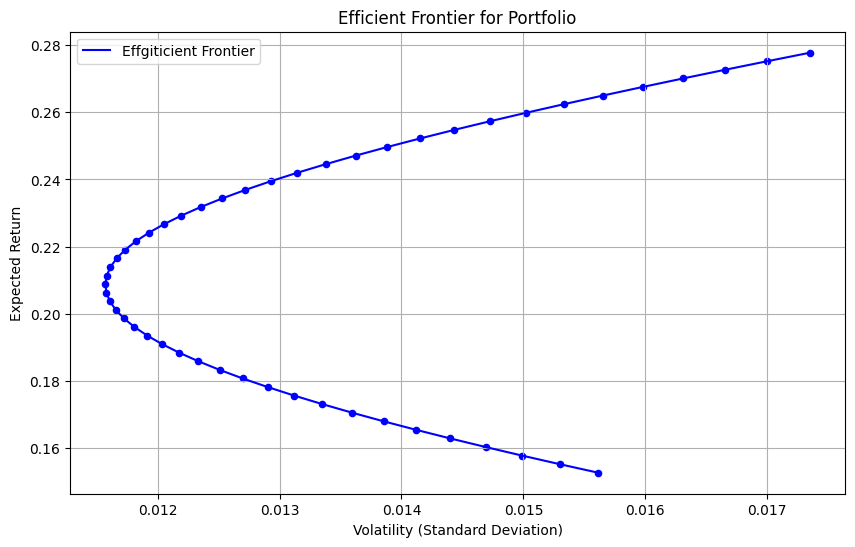

array([0.62883361, 0.37116639])

In [37]:
class Optimizer:
    def __init__(self,stocks:list,start_year_previous = 5):
        self.stocks = stocks
        #history is stored as {"symbol":{"close: []"
        #                                 "open":[]
        #                                 "time":[]}}
        #                      
        self.history = defaultdict(dict)
        #calculate date
        today = datetime.date.today()  
        start = str(today.replace(year=today.year - start_year_previous))
        end = str(today.replace(day=today.day - 1))
        # insert data into dictionary
        for i, stock in enumerate(self.stocks):
            data = Helper.historical_data(stock= stock, start_date= start,end_date= end, engine= "vnstock"
                                          ,include = ["close"])
            self.history[stock] = data["close"]
        
        
        # calculate covariance right away here
        self.hpr_df = pd.DataFrame(self.history).pct_change().dropna()
        self.annualized_hpr = self.hpr_df.mean() *252
        self.cov_matrix = self.hpr_df.cov()
    def calculate_variance(self,weight:list):
        weight = np.array(weight)

        return weight @ self.cov_matrix @ weight 
    def calculate_return(self,weight:list):
        weight = np.array(weight)
        return weight@self.annualized_hpr 

    def optimize_portfolio(self, target_return):
        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: self.calculate_return(w) - target_return}
        )
        bounds = tuple((0, 1) for _ in range(len(self.stocks)))
        initial_guess = np.array(len(self.stocks) * [1. / len(self.stocks)])
        
        result = minimize(self.calculate_variance, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            return result.fun**0.5, target_return, result.x  # Return volatility, target return, weights
        else:
            print(f"Optimization failed for target_return={target_return}. Message: {result.message}")
            return None
    def find_MVP(self):

        one_matrix = np.ones((self.cov_matrix.shape[0],1))
        w = np.linalg.inv(self.cov_matrix) @ one_matrix
        self.mvp_w = Helper.normalize_to_1(w)
        return self.mvp_w
    def find_OP(self,risk_free_rate = 0.04):

        excess_return = self.annualized_hpr - risk_free_rate
        w = np.linalg.inv(self.cov_matrix) @ excess_return
        self.op_w = Helper.normalize_to_1(w)
        return self.op_w
    def efficient_frontier(self,draw=True):
        min_return = self.annualized_hpr.min()
        max_return = self.annualized_hpr.max()
        if pd.isna(min_return) or pd.isna(max_return):
            print("Invalid return range. Check data.")
        else:
            target_returns = np.linspace(min_return, max_return, 50)
            frontier = []
            for tr in target_returns:
                res = self.optimize_portfolio(tr)
                if res:
                    frontier.append(res)

            if draw:
                volatilities, returns, _ = zip(*frontier)
                plt.figure(figsize=(10, 6))
                plt.plot(volatilities, returns, 'b-', label='Effgiticient Frontier')
                plt.scatter(volatilities, returns, c='blue', s=20)
                plt.xlabel('Volatility (Standard Deviation)')
                plt.ylabel('Expected Return')
                plt.title('Efficient Frontier for Portfolio')
                plt.grid(True)
                plt.legend()
                plt.show()
            else:
                print("No valid points on the efficient frontier. Check data or target returns.")


op = Optimizer(stocks=["ACB","VCB"])
op.efficient_frontier()
op.find_MVP()
op.find_OP()

In [41]:
op.find_OP().shape

(2,)

In [18]:


class Stock_data:
    def __init__(self,stock:Vnstock.stock):
        self.stock = stock
        #calculate date
        
        today = datetime.date.today()
        start = today.replace(year=today.year - 5)
        end = today.replace(day=today.day - 1)
        #modify history by adding shift 1 day then remove the first row
        self.history = self.stock.quote.history(start = str(start),end = str(end),interval = "1D")
        self.history["close_shift_1"] = self.history["close"].shift(1)
        self.history = self.history.iloc[1:,:]
    def hpr(self,display_option = False):

        #calculate hpr day
        self.history["hpr"] = (self.history["close"]- self.history["close_shift_1"]) / self.history["close_shift_1"]
        if display_option:
            display(self.history)
    def arithmethic_mean(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        self.a_mean = self.history["hpr"].mean()
        return self.a_mean
    def geometric_mean(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        growth_factors = 1 + self.history["hpr"]
        self.geo_mean = np.prod(growth_factors) ** (1 / len(growth_factors)) - 1
        return self.geo_mean
    def standard_deviation(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        self.std_dev = self.history["hpr"].std()  
        return self.std_dev
    def annualize(self):
        if hasattr(self, 'std_dev') and hasattr(self, 'a_mean') and hasattr(self, 'geo_mean'):
            trading_days = 252  # typical number of trading days in a year
            annualized_mean = (1 + self.geo_mean) ** trading_days - 1
            annualized_std = self.std_dev * np.sqrt(trading_days)
            annualized_amean = self.a_mean * trading_days
            return {
                    "Annualized_arithmethic_mean": annualized_amean,
                    "Annualized_geometric_mean": annualized_mean,
                    "Annualized_std": annualized_std,
                    
            }
        else:
            raise AttributeError("Please calculate mean, geometric mean, and standard deviation before annualizing.")



In [ ]:
class Helper:
    def __init__(self):
        pass
    @staticmethod
    def normalize_to_1(mat):
        total = np.sum(mat)
        return mat / total
    @staticmethod
    def find_risk_free_rate()

In [ ]:
import pandas as pd
from vnstock import Vnstock
import datetime
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
import matplotlib.pyplot as plt
class Portfolio():
    def __init__(self, stocks: list, weight_list: list, start_year_previous=5,):
        #check if weight = 1
        if not weight_list:
            weight_list = [1/len(stocks)]*len(stocks)
            print(weight_list) 
        if len(weight_list) != len(stocks):
            raise ValueError("Length of weight_list must equal length of stocks")
        if np.sum(weight_list) != 1:
            raise ValueError("Sum of weights must equal 1")
        #initialize variables
        self.stocks = stocks
        self.weight_list = weight_list
        self.history = defaultdict(list)
        #calculate date
        today = datetime.date.today()  # 02:16 PM +07, Aug 29, 2025
        start = today.replace(year=today.year - start_year_previous)
        end = today.replace(day=today.day - 1)
        # insert data into dictionary
        for i, stock in enumerate(self.stocks):
            stock_obj = Vnstock().stock(symbol=stock, source="VCI")
            stock_data = stock_obj.quote.history(start=str(start), end=str(end), interval="1D")
            if stock_data.empty:
                print(f"No data for {stock}")
                continue
            self.history["time"].append(stock_data["time"].copy())
            self.history["open"].append(stock_data["open"].copy())
            self.history["close"].append(stock_data["close"].copy())
            self.history["symbol"].append(stock)
            self.history["weight"].append(weight_list[i])
    def export_history(self):
        history_df = self.history
        return history_df
    def calculate_hpr(self, display_option=False):
        #create hpr_df table
        self.hpr_df = pd.DataFrame(columns=["stocks", "annualized_return"])
        #expand the dictionary to df, and calculate pct change ( hpr)
        for i in range(len(self.stocks)):
            data = pd.DataFrame({
                "time": self.history["time"][i],
                "close": self.history["close"][i]
            })
            data["return"] = data["close"].pct_change().dropna()
            if data["return"].empty:
                print(f"No valid returns for {self.stocks[i]}")
                continue
        #annualize
            overall_return = data["return"].mean() * 252  # Annualized return
            self.hpr_df = pd.concat([self.hpr_df, pd.DataFrame({"stocks": [self.stocks[i]], "annualized_return": [overall_return]})], ignore_index=True)
        if display_option:
            print(self.hpr_df)
        return self.hpr_df

    def portfolio_return(self, weights):
        hpr = pd.concat([pd.Series(self.history["close"][i]).pct_change().dropna() for i in range(len(self.stocks))], axis=1)
        if hpr.empty or hpr.isna().all().any():
            print("Warning: Empty or NaN data in returns")
            return 0.0
        hpr.columns = self.stocks
        hpr_annualized = hpr.mean() * 252  # Annualized daily returns
        return np.dot(weights, hpr_annualized)

    def portfolio_variance(self, weights):
        hpr = pd.concat([pd.Series(self.history["close"][i]).pct_change().dropna() for i in range(len(self.stocks))], axis=1)
        if hpr.empty or hpr.isna().all().any():
            print("Warning: Empty or NaN data in returns")
            return 0.0
        hpr.columns = self.stocks
        self.cov_matrix = hpr.cov() * 252  # Annualize covariance
        if np.any(np.isnan(self.cov_matrix)):
            print("Warning: NaN in covariance matrix")
            return 0.0
        return np.dot(weights.T, np.dot(self.cov_matrix, weights))

    def optimize_portfolio(self, target_return):
        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: self.portfolio_return(w) - target_return}
        )
        bounds = tuple((0, 1) for _ in range(len(self.stocks)))
        initial_guess = np.array(len(self.stocks) * [1. / len(self.stocks)])
        
        result = minimize(self.portfolio_variance, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            return result.fun**0.5, target_return, result.x  # Return volatility, target return, weights
        else:
            print(f"Optimization failed for target_return={target_return}. Message: {result.message}")
            return None
    def find_MVP(self):
        # larange multiplier w proportional to cov ^-1 . 1
        if not hasattr(self,"cov_matrix"):
            self.portfolio_variance(weights=np.array(self.weight_list))
        one_matrix = np.ones((self.cov_matrix.shape[0],1))
        w = np.linalg.inv(self.cov_matrix) @ one_matrix
        self.mvp_w = Helper.normalize_to_1(w)
        return self.mvp_w
    def find_OP(self):
        if not hasattr(self,"cov_matrix"):
            self.portfolio_variance(weights=np.array(self.weight_list))
        excess_return = np
    def draw_efficient_frontier(self):
        min_return = self.hpr_df["annualized_return"].min()
        max_return = self.hpr_df["annualized_return"].max()
        if pd.isna(min_return) or pd.isna(max_return):
            print("Invalid return range. Check data.")
        else:
            target_returns = np.linspace(min_return, max_return, 50)
            frontier = []
            for tr in target_returns:
                res = self.optimize_portfolio(tr)
                if res:
                    frontier.append(res)

            if frontier:
                volatilities, returns, _ = zip(*frontier)
                plt.figure(figsize=(10, 6))
                plt.plot(volatilities, returns, 'b-', label='Effgiticient Frontier')
                plt.scatter(volatilities, returns, c='blue', s=20)
                plt.xlabel('Volatility (Standard Deviation)')
                plt.ylabel('Expected Return')
                plt.title('Efficient Frontier for Portfolio')
                plt.grid(True)
                plt.legend()
                plt.show()
            else:
                print("No valid points on the efficient frontier. Check data or target returns.")
        # Initialize portfolio
    def display_result(self):
        # Check if results exist, if not, calculate
        if not hasattr(self, "hpr_df"):
            self.calculate_hpr()
        if not hasattr(self, "history") or not self.history["close"]:
            print("No portfolio history available.")
            return

        weights = np.array(self.weight_list)
        port_return = self.portfolio_return(weights)
        port_variance = self.portfolio_variance(weights)
        port_volatility = np.sqrt(port_variance)

        # Portfolio statistics in one DataFrame
        stats_df = pd.DataFrame({
            "Expected Annualized Return": [port_return],
            "Annualized Variance": [port_variance],
            "Annualized Stdev": [port_volatility]
        })
        print("Portfolio Statistics:")
        display(stats_df)

        # Prepare returns for covariance/correlation
        returns = pd.concat([pd.Series(self.history["close"][i]).pct_change().dropna() for i in range(len(self.stocks))], axis=1)
        returns.columns = self.stocks

        cov_matrix = returns.cov() * 252
        cor_matrix = returns.corr()

        print("Covariance Matrix (annualized):")
        display(cov_matrix)
        print("Correlation Matrix:")
        display(cor_matrix)
portfolio = Portfolio(stocks=["ACB", "VCB", "VIC","HPG","VIX"], weight_list=[0.1, 0.3, 0.3,0.1,0.2], start_year_previous=25)




1.0

In [ ]:
import numpy as np
arr = np.ones((3,1))  # 3x3 array of ones
print(arr)
np.invert(arr)

[[1.]
 [1.]
 [1.]]


TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

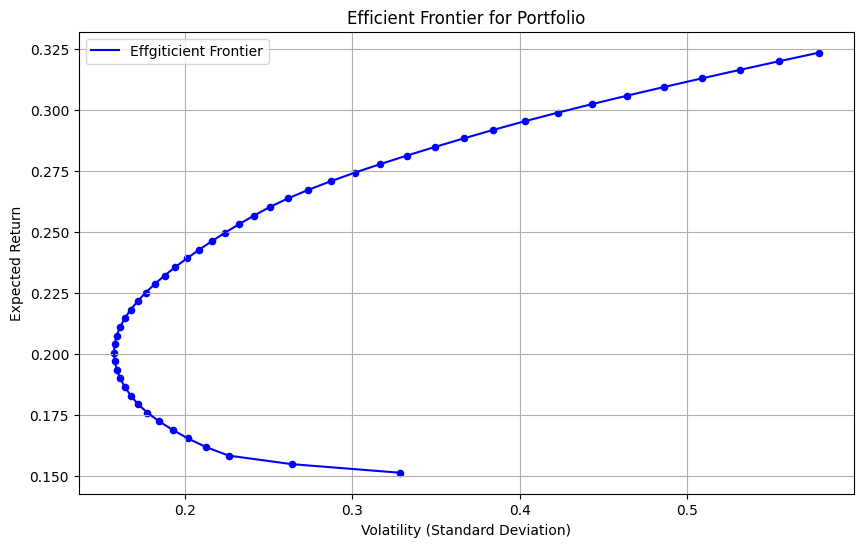

In [ ]:
portfolio.draw_efficient_frontier()